In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
def count_el(lista):
    stos = [lista]
    licznik = 0
    while stos:
        aktualna_lista = stos.pop()
        for element in aktualna_lista:
            if isinstance(element, (list, tuple)):
                stos.append(element)
            else:
                licznik += 1
    return licznik

In [5]:
# Filtrowanie data_tr
filtered_data_tr = []
for onto, X, y in zip(data_tr[0], data_tr[1], data_tr[2]):
    if count_el(X) <= 3:
        filtered_data_tr.append([onto, X, y])

# Przekształcenie z powrotem do oryginalnego formatu
new_data_tr = [[], [], []]
for item in filtered_data_tr:
    new_data_tr[0].append(item[0])
    new_data_tr[1].append(item[1])
    new_data_tr[2].append(item[2])

# Przypisanie przefiltrowanych danych z powrotem do data_tr
data_tr = new_data_tr

print(f"Liczba elementów po filtrowaniu: {len(data_tr[0])}")

Liczba elementów po filtrowaniu: 39894


In [6]:
# Filtrowanie data_tr
filtered_data_vl = []
for onto, X, y in zip(data_vl[0], data_vl[1], data_vl[2]):
    if count_el(X) >= 4:
        filtered_data_vl.append([onto, X, y])

# Przekształcenie z powrotem do oryginalnego formatu
new_data_vl = [[], [], []]
for item in filtered_data_vl:
    new_data_vl[0].append(item[0])
    new_data_vl[1].append(item[1])
    new_data_vl[2].append(item[2])

# Przypisanie przefiltrowanych danych z powrotem do data_tr
data_vl = new_data_vl

print(f"Liczba elementów po filtrowaniu: {len(data_vl[0])}")

Liczba elementów po filtrowaniu: 6053


In [7]:
emb_size = 10
hidden_size = 16
epoch_count = 10
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size, identities_weight=0.02, identitity_weight_decay=0.95)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/10 | batch 1248/1247 | loss 0.9737 | val loss 0.7733 | acc 0.2057 | f1 0.3412 | prec 0.2057 | recall 1.0000 | roc auc 0.5065 | pr auc 0.2415 | elapsed 17.55s
train epoch 01/10 | batch 1248/1247 | loss 0.8164 | val loss 0.5599 | acc 0.7994 | f1 0.2552 | prec 0.5403 | recall 0.1671 | roc auc 0.5686 | pr auc 0.3578 | elapsed 36.76s
train epoch 02/10 | batch 1248/1247 | loss 0.5996 | val loss 0.4600 | acc 0.8227 | f1 0.4670 | prec 0.6120 | recall 0.3775 | roc auc 0.7350 | pr auc 0.5541 | elapsed 36.46s
train epoch 03/10 | batch 1248/1247 | loss 0.4526 | val loss 0.4348 | acc 0.8283 | f1 0.5535 | prec 0.5952 | recall 0.5173 | roc auc 0.7772 | pr auc 0.6153 | elapsed 37.11s
train epoch 04/10 | batch 1248/1247 | loss 0.3542 | val loss 0.4399 | acc 0.8262 | f1 0.5789 | prec 0.5770 | recall 0.5807 | roc auc 0.7978 | pr auc 0.6557 | elapsed 35.94s
train epoch 05/10 | batch 1248/1247 | loss 0.2874 |

In [8]:
# Filtrowanie data_tr
filtered_data_te = []
for onto, X, y in zip(data_te[0], data_te[1], data_te[2]):
    if count_el(X) >= 4:
        filtered_data_te.append([onto, X, y])

# Przekształcenie z powrotem do oryginalnego formatu
new_data_te = [[], [], []]
for item in filtered_data_te:
    new_data_te[0].append(item[0])
    new_data_te[1].append(item[1])
    new_data_te[2].append(item[2])

# Przypisanie przefiltrowanych danych z powrotem do data_tr
data_te_te = new_data_te

print(f"Liczba elementów po filtrowaniu: {len(data_te_te[0])}")

Liczba elementów po filtrowaniu: 15217


In [9]:
# Filtrowanie data_tr
filtered_data_te = []
for onto, X, y in zip(data_te[0], data_te[1], data_te[2]):
    if count_el(X) < 4:
        filtered_data_te.append([onto, X, y])

# Przekształcenie z powrotem do oryginalnego formatu
new_data_te = [[], [], []]
for item in filtered_data_te:
    new_data_te[0].append(item[0])
    new_data_te[1].append(item[1])
    new_data_te[2].append(item[2])

# Przypisanie przefiltrowanych danych z powrotem do data_tr
data_te_tr = new_data_te

print(f"Liczba elementów po filtrowaniu: {len(data_te_tr[0])}")

Liczba elementów po filtrowaniu: 24783


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': data_te_te[0],
    'X': data_te_te[1],
    'y': data_te_te[2]
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.5, val_size=0.5):
    groups = data[group_col].unique()
    val_idx, test_idx = [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        val_data, test_data = train_test_split(group_data, test_size=test_size, stratify=group_data[stratify_col], random_state=seed)

        val_idx.extend(val_data.index)
        test_idx.extend(test_data.index)

    return data.loc[val_idx], data.loc[test_idx]

val_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.5, val_size=0.5)


X_te_val = val_data['X'].tolist()
y_te_val = val_data['y'].tolist()
idx_te_val = val_data['ontology_id'].tolist()

data_te_vl = [idx_te_val, X_te_val, y_te_val] 

X_te_te =  test_data['X'].tolist()
y_te_te = test_data['y'].tolist()
idx_te_te = test_data['ontology_id'].tolist()


In [ ]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 776/775 | loss 0.9664 | val loss 1.1422 | acc 0.6569 | f1 0.4285 | prec 0.3217 | recall 0.6413 | roc auc 0.7091 | pr auc 0.5102 | elapsed 5.63s
train epoch 01/10 | batch 776/775 | loss 0.8476 | val loss 0.9924 | acc 0.6847 | f1 0.4538 | prec 0.3476 | recall 0.6531 | roc auc 0.7379 | pr auc 0.5419 | elapsed 9.84s
train epoch 02/10 | batch 776/775 | loss 0.6179 | val loss 0.8791 | acc 0.7049 | f1 0.4769 | prec 0.3700 | recall 0.6708 | roc auc 0.7638 | pr auc 0.5738 | elapsed 10.36s
train epoch 03/10 | batch 776/775 | loss 0.4542 | val loss 0.7962 | acc 0.7240 | f1 0.5018 | prec 0.3932 | recall 0.6931 | roc auc 0.7854 | pr auc 0.6029 | elapsed 10.55s
train epoch 04/10 | batch 776/775 | loss 0.3432 | val loss 0.7362 | acc 0.7383 | f1 0.5226 | prec 0.4120 | recall 0.7141 | roc auc 0.8035 | pr auc 0.6297 | elapsed 9.99s
train epoch 05/10 | batch 776/775 | loss 0.2705 | val loss 0.6921 | acc 0.7492 | f1 0.5357 | prec 0.4260 | recall 0.7213 | roc auc 

In [12]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240712T164849


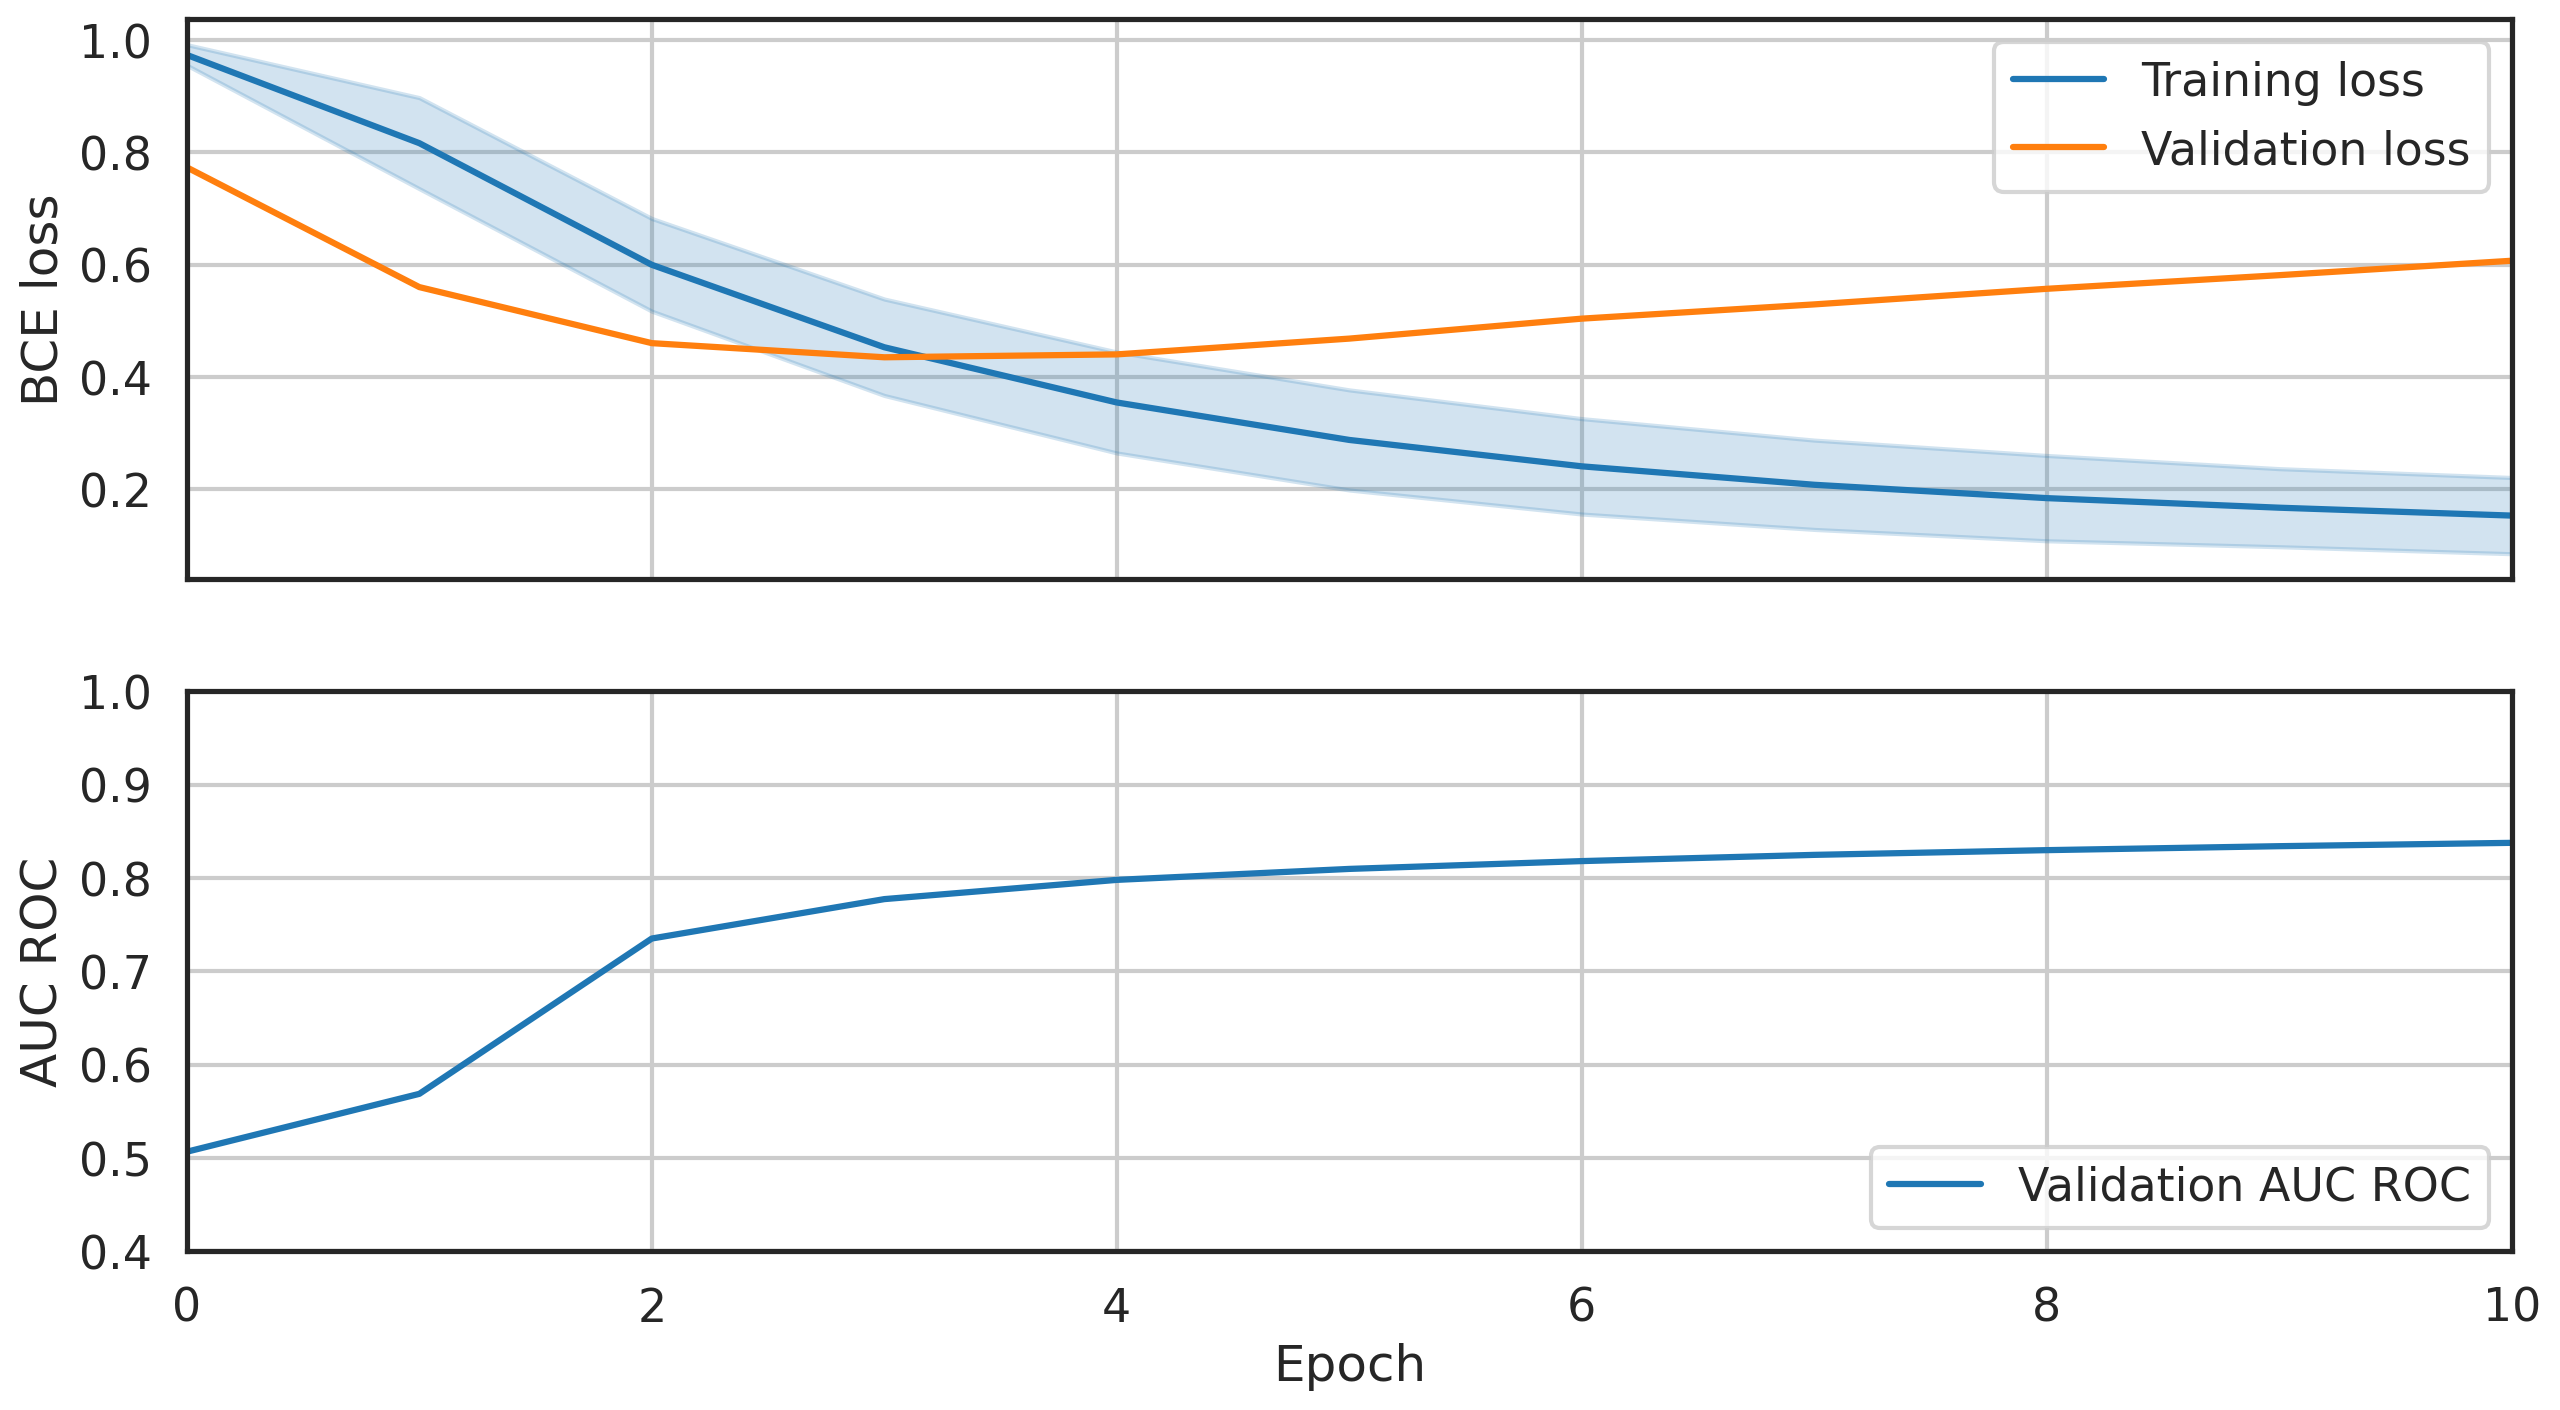

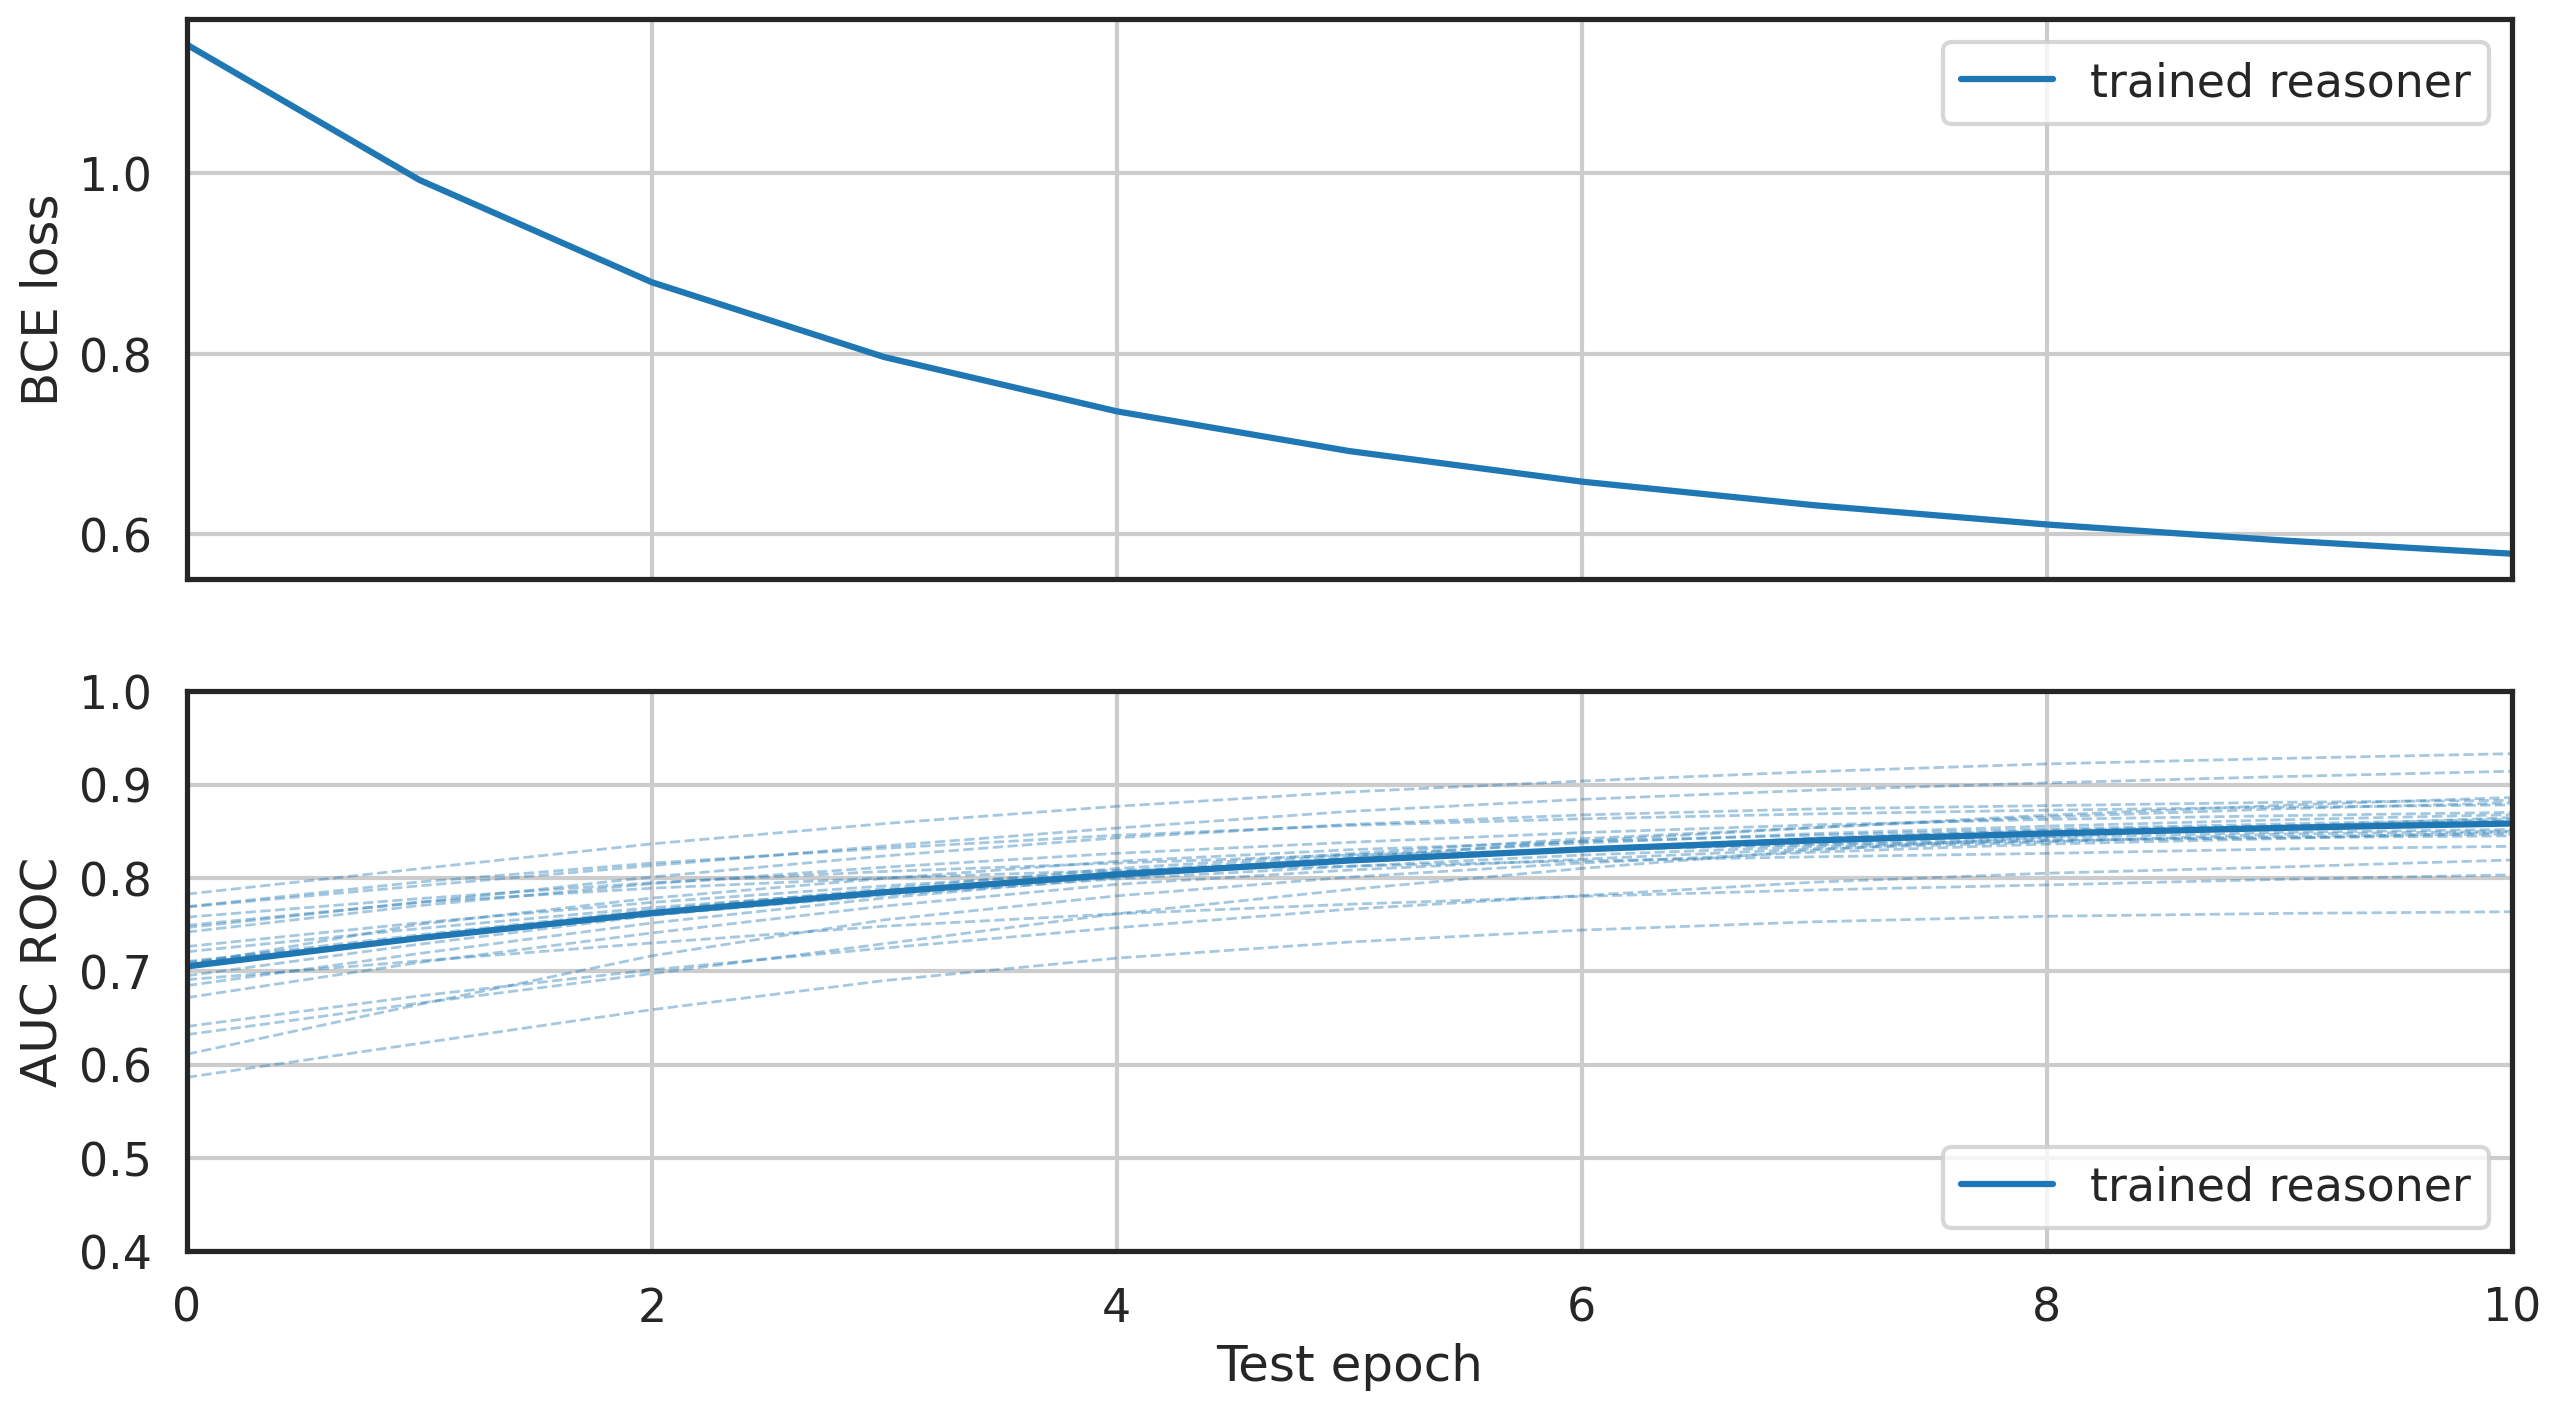

             mean       std     micro
acc      0.792873  0.042654  0.793090
prec     0.492571  0.076124  0.490933
recall   0.744650  0.077817  0.741683
f1       0.588723  0.063658  0.590803
auc_roc  0.851265  0.036915  0.850815
auc_pr   0.712582  0.082745  0.718801


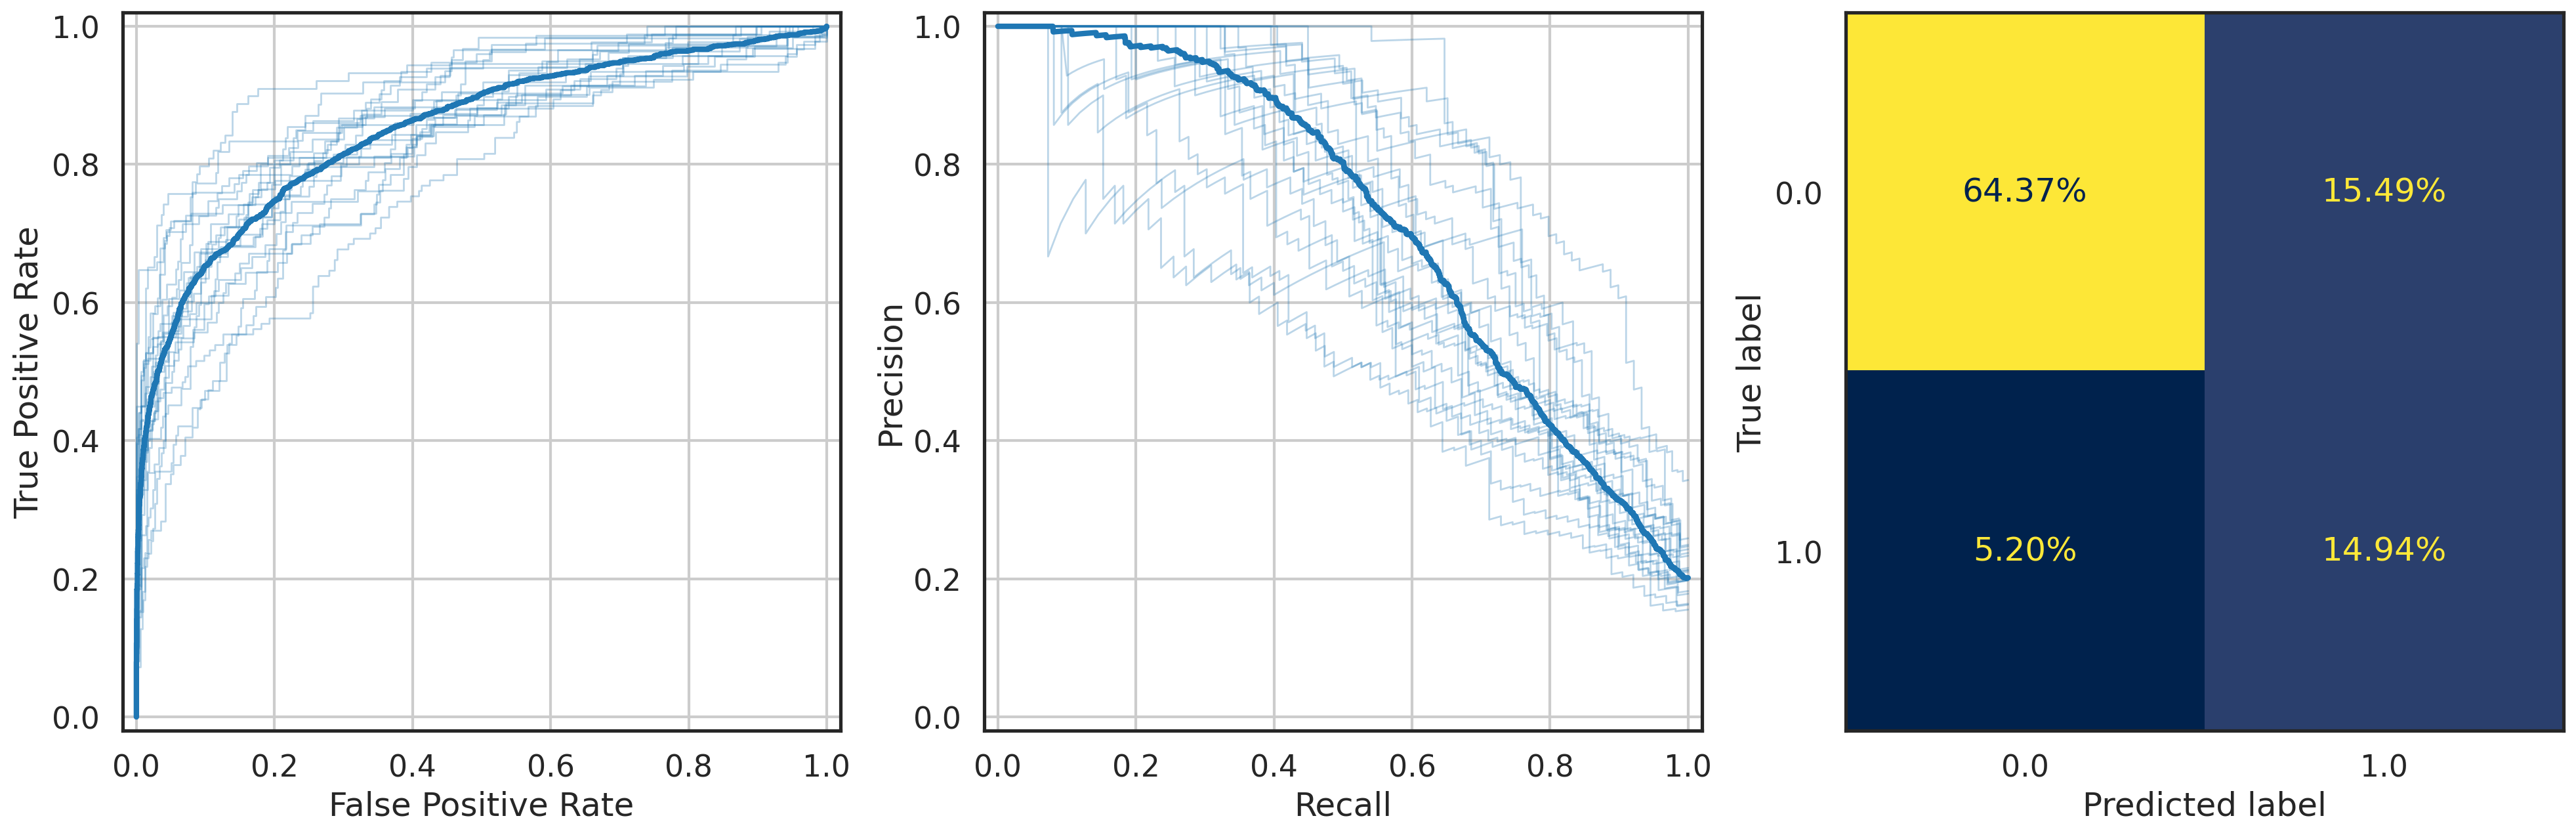

In [13]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [14]:
import random

In [15]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im( input, input)))
print(np.mean(losses))

tensor([-0.0546,  0.1709, -0.1797, -0.2237, -0.1197, -0.0902, -0.1556, -0.1432,
         0.0707, -0.0433], grad_fn=<SelectBackward0>)
tensor([ 0.2420, -0.0336,  0.1659, -0.2422,  0.2358, -0.0861, -0.0577, -0.0660,
        -0.0666,  0.0754], grad_fn=<AddBackward0>)
0.14236214570701122


In [16]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.4760,  0.2573,  0.1594, -0.3355,  0.4827, -0.0285,  0.1249,  0.1829,
        -0.3301, -0.2500], grad_fn=<SelectBackward0>)
tensor([ 0.5477,  0.3070,  0.1517, -0.3636,  0.5353, -0.0087,  0.1950,  0.2690,
        -0.3835, -0.2684], grad_fn=<AddBackward0>)
0.04336929582059383


In [17]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([-0.1665,  0.0047,  0.1352, -0.1970,  0.0770, -0.2086,  0.0860, -0.0384,
         0.0273,  0.1524], grad_fn=<SelectBackward0>)
tensor([-0.0024, -0.0263,  0.0414, -0.0591,  0.0217, -0.0809, -0.0061, -0.0350,
         0.0088,  0.0318], grad_fn=<AddBackward0>)
0.0723559770733118


In [18]:
losses = []
for _ in range(20):

    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.4760,  0.2573,  0.1594, -0.3355,  0.4827, -0.0285,  0.1249,  0.1829,
        -0.3301, -0.2500], grad_fn=<SelectBackward0>)
tensor([ 0.1575, -0.0249,  0.1766, -0.1848,  0.2038, -0.1424, -0.1031, -0.0780,
        -0.0845,  0.0125], grad_fn=<AddBackward0>)
0.18845096826553345


In [19]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.4760,  0.2573,  0.1594, -0.3355,  0.4827, -0.0285,  0.1249,  0.1829,
        -0.3301, -0.2500], grad_fn=<SelectBackward0>)
tensor([ 0.4760,  0.2573,  0.1593, -0.3353,  0.4826, -0.0282,  0.1249,  0.1828,
        -0.3301, -0.2500], grad_fn=<SqueezeBackward3>)
tensor(7.9473e-05, grad_fn=<L1LossBackward0>)


In [20]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-0.0691, -0.5064, -0.0975,  0.5961,  0.0975,  0.4872,  1.2635,  0.0071,
        -0.2923,  0.5282], grad_fn=<SelectBackward0>)
tensor([-0.0691, -0.5066, -0.0975,  0.5963,  0.0976,  0.4872,  1.2636,  0.0071,
        -0.2925,  0.5284], grad_fn=<SqueezeBackward3>)
tensor(0.0001, grad_fn=<L1LossBackward0>)


In [21]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))), trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))))
print(trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.2723,  0.0290,  0.1118, -0.2211,  0.2303, -0.0261, -0.0410,  0.0095,
        -0.1117, -0.0085], grad_fn=<AddBackward0>)
tensor([ 0.2139,  0.0185,  0.1623, -0.2262,  0.2551, -0.0916, -0.0135, -0.0351,
        -0.0921, -0.0181], grad_fn=<AddBackward0>)
0.024333349801599978


In [22]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im(input1, input2)), trained_reasoner.and_nn(im(input2, input1))).item())

print(trained_reasoner.and_nn(im(input1, input2)))
print(trained_reasoner.and_nn(im(input2, input1)))

print(np.mean(losses))

tensor([ 0.1894, -0.0297,  0.1205, -0.2082,  0.1919, -0.1320, -0.0829, -0.0992,
        -0.0222,  0.0114], grad_fn=<AddBackward0>)
tensor([ 0.2083, -0.0153,  0.1411, -0.2119,  0.1839, -0.1052, -0.0582, -0.0837,
        -0.0402, -0.0033], grad_fn=<AddBackward0>)
0.027635673619806768


In [23]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([-0.1391, -0.3414, -0.0623, -0.0257, -0.0675, -0.1196, -0.0426,  0.0598,
        -0.1475,  0.1788], grad_fn=<SelectBackward0>)
tensor([-0.1546, -0.2098, -0.0280,  0.0198, -0.1450, -0.0990, -0.0936, -0.0669,
         0.0139,  0.1746], grad_fn=<AddBackward0>)
0.07109428942203522


In [24]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9996422946453094


In [25]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9999852180480957
